# Introduction
In this demonstration, we will implement a generative adversarial network (GAN) to generate random new realistic images of clothing apparels by training it on the fashion-MNIST dataset from `keras`. The objective of this demonstration is to motivate the importance of latent spaces and how they can be used to generate new images.

## Setup
Let us import the necessary packages and methods for this demonstration:
- Working with numeric structures: `numpy`
- Working with images: `matplotlib.pyplot`
- Working with artificial neural networks: `tensorflow`, `keras`

In [ ]:
# Load necessary methods and packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

## Data
Let us load the fashion-MNIST dataset and study the images that we are working with.

In [ ]:
# Import the 'fashion_mnist' data package from 'keras'
from keras.datasets import fashion_mnist

# Load the data
(X_train, _), (X_test, _) = fashion_mnist.load_data()

# Undo the train-test split
X = np.concatenate([X_train, X_test], axis = 0)

# Normalize the pixel gray levels
X = np.expand_dims(X, -1).astype('float32') / 255

GANs are used for random image generation and hence follow a different training regime. Because of this, we have the following considerations:
- We do not need the $y$ values that are generally used for classification
- We do not need a train-test split

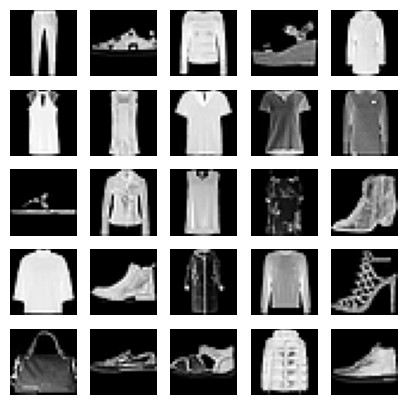

In [ ]:
# Sample a few fashion MNIST images from the data and view the images
indices = np.random.randint(0, X.shape[0], size = 25)

images = X[indices]

plt.figure(figsize = (5, 5))

for i in np.arange(0, len(indices), 1):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')

You can see that the fashion-MNIST data are grayscale images of size 28x28 of various clothing apparels such as shoes, shirts, and so on.

In [ ]:
# Study the shape of the data
print('Data shape: ', X.shape) # (70000, 28, 28, 1) --- 70000 images, each 28x28 pixels

Data shape:  (70000, 28, 28, 1)


# Part 1 - Building the GAN
In this section, we will construct the components of the GAN but we will not combine them into a single model. This is because we need to discard the discriminator at the end anyway. Note that the GAN is primarily comprised of the generator and the discriminator during training and only the generator during inference.

### Generator
The generator (G) is designed to map the latent space vector $z$ to the image space.

Let's define a function to build the generator. The generator is essentially a combination of a fully connected layer followed by transpose convolutional layers that produce images at the end.

In [ ]:
# Define the generator
def build_generator(latent_dim = 1):
    G = keras.models.Sequential([layers.Dense(28 * 28 * 256, use_bias = False, input_shape = (latent_dim,)),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 layers.Reshape((28, 28, 256)),
                                 layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 1, use_bias = False, padding = 'same'),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, use_bias = False, padding = 'same'),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 1, use_bias = False, padding = 'same'),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, use_bias = False, padding = 'same')])

    return G

### Discriminator
The discriminator (D) is designed to be able to tell the difference between a real image and an image that is generated by the generator.

Let's define a function to build the discriminator. The discriminator is a combination of convolutioanl layers and a fully connected at the end to classify incoming images.

In [ ]:
# Define the discriminator
def build_discriminator():
    D = keras.models.Sequential([layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, use_bias = False, padding = 'same', input_shape = (28, 28, 1)),
                                 layers.LeakyReLU(),
                                 layers.Dropout(rate = 0.3),
                                 layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias = False, padding = 'same'),
                                 layers.LeakyReLU(),
                                 layers.Dropout(rate = 0.3),
                                 layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, use_bias = False, padding = 'same'),
                                 layers.LeakyReLU(),
                                 layers.Dropout(rate = 0.3),
                                 layers.Flatten(),
                                 layers.Dense(units = 1, use_bias = False)])

    return D

Now that the generator and the discriminator have been defined, we can instantiate them as components of the GAN.

In [ ]:
# Set a latent vector size
latent_dim = 4

GANs also use random vectors from a latent space to generate new images.

In [ ]:
# Create generator
generator = build_generator(latent_dim = latent_dim)

# Print the summary of the model
generator.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 200704)            802816    
                                                                 
 batch_normalization_52 (Ba  (None, 200704)            802816    
 tchNormalization)                                               
                                                                 
 leaky_re_lu_92 (LeakyReLU)  (None, 200704)            0         
                                                                 
 reshape_19 (Reshape)        (None, 28, 28, 256)       0         
                                                                 
 conv2d_transpose_52 (Conv2  (None, 28, 28, 128)       294912    
 DTranspose)                                                     
                                                                 
 batch_normalization_53 (Ba  (None, 28, 28, 128)     

In [ ]:
# Create discriminator
discriminator = build_discriminator()

# Print the summary of the model
discriminator.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 32)        288       
                                                                 
 leaky_re_lu_96 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 dropout_40 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 64)        18432     
                                                                 
 leaky_re_lu_97 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 dropout_41 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 128)     

# Part 2 - Training the Network
In this section, we will define loss functions for the GAN and train it.

In [ ]:
# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [ ]:
# Set a batch size and a number of epochs
batch_size = 64
n_epochs = 5

In [ ]:
# Define the training step
@tf.function
def train_step(images = None, batch_size = 1, latent_dim = 1):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# Run the training loop
n_batches = X.shape[0] // batch_size
loss_comps = n_epochs * n_batches
i = 0
for epoch in range(n_epochs):
    for batch in range(n_batches):
        i = i + 1
        print('Parameter updates using loss computation number {} out of {} computations...'.format(i, loss_comps))
        batch_images = X[batch * batch_size : (batch + 1) * batch_size]
        train_step(images = batch_images, batch_size = batch_size, latent_dim = latent_dim)

Streaming output truncated to the last 5000 lines.
Parameter updates using loss computation number 466 out of 5465 computations...
Parameter updates using loss computation number 467 out of 5465 computations...
Parameter updates using loss computation number 468 out of 5465 computations...
Parameter updates using loss computation number 469 out of 5465 computations...
Parameter updates using loss computation number 470 out of 5465 computations...
Parameter updates using loss computation number 471 out of 5465 computations...
Parameter updates using loss computation number 472 out of 5465 computations...
Parameter updates using loss computation number 473 out of 5465 computations...
Parameter updates using loss computation number 474 out of 5465 computations...
Parameter updates using loss computation number 475 out of 5465 computations...
Parameter updates using loss computation number 476 out of 5465 computations...
Parameter updates using loss computation number 477 out of 5465 compu

# Part 3 - Generating Images
In this section, we will generate some new images using the generator component of the GAN.

In [ ]:
# Choose a number of new images to generate
n_new = 25

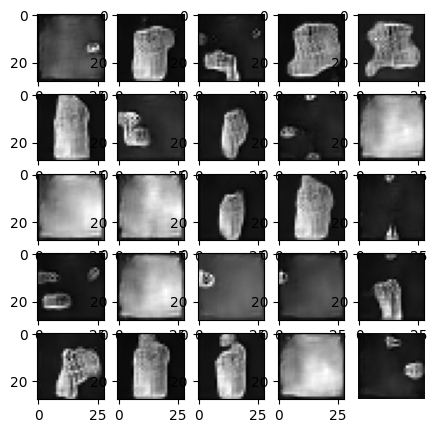

In [ ]:
# Generate some new images using the generator
noise = tf.random.normal([n_new, latent_dim])
generated_images = generator(noise, training = False)

# Rescale the image gray levels to [0, 1]
generated_images = 0.5 * generated_images + 0.5

plt.figure(figsize = (5, 5))

for i in range(n_new):
    plt.subplot(int(np.sqrt(n_new)), int(np.sqrt(n_new)), i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap = 'gray')

plt.axis('off')
plt.show()